# Exploration of DoC consumer complaint data

### To jumpstart your intuition and analysis
#### `everett@bayesimpact.org`

In [1]:
DATA_FILE = '../data-cleaned/commerce-consumer-complaints.csv'

In [2]:
####################################################
# Boilerplate import/setup code for general analysis
####################################################

import datetime as dt
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Useful colors to reference
SNS_BLUE, SNS_GREEN, SNS_RED, SNS_PURPLE, SNS_YELLOW, SNS_CYAN = sns.color_palette()
# sns.set_palette(sns.color_palette("cubehelix", 8))
pd.set_option('display.max_columns', 500)
plt.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

####################################################
# everett@bayesimpact.org
####################################################

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Helper functions (used later)

In [3]:
# Helpers (currently cut and paste around different notebooks... oops)

def percentify_axis(ax, which):
    which = which.lower()
    if which in ('x', 'both'):
        ax.set_xticklabels(['%.0f%%' % (t*100) for t in ax.get_xticks()])
    if which in ('y', 'both'):
        ax.set_yticklabels(['%.0f%%' % (t*100) for t in ax.get_yticks()])

color_idx = 0
CYCLE_COLORS = sns.color_palette()
def next_color():
    global color_idx
    c = CYCLE_COLORS[color_idx] 
    color_idx = (color_idx + 1) % len(CYCLE_COLORS)
    return c

def count_unique(s):
    values = s.unique()
    return sum(1 for v in values if pd.notnull(v))

def missing_pct(s):
    missing = N - s.count()
    return missing * 100.0 / N

def complete_pct(s):
    return 100 - missing_pct(s)

def summarize_completeness_uniqueness(df):
    print '*** How complete is each feature? How many different values does it have? ***'
    rows = []
    for col in df.columns:
        rows.append([col, '%.0f%%' % complete_pct(df[col]), count_unique(df[col])])
    return pd.DataFrame(rows, columns=['Column Name', 'Complete (%)','Unique Values'])

def summarize_completeness_over_time(df, time_col, transpose=True):
    print '*** Data completeness over time per column ***'
    x = df.groupby(time_col).count()
    x = x.div(df.groupby(time_col).size(), axis=0)
    for col in x.columns:
        x[col] = x[col].apply(lambda value: '%.0f%%' % (value * 100))
    if transpose:
        return x.T
    return x

def plot_top_hist(df, col, top_n=10, skip_below=.01):
    '''Plot a histogram of a categorical dataframe column, limiting to the most popular.'''
    counts = df[col].value_counts(True, ascending=True)
    if counts.max() < skip_below:
        print 'Skipping "%s" histogram -- most common value is < %.0f%% of all cases' % (col, skip_below*100)
        return
    fig, ax = plt.subplots(1)
    explanation = ''
    if len(counts) > top_n:
        explanation = ' (top %d of %d)' % (top_n, len(counts))
        counts = counts.iloc[-top_n:]
    explanation += ' -- %.0f%% missing' % (missing_pct(df[col]))
    counts.plot(kind='barh', ax=ax, color=next_color())
    ax.set_title('Rows by "%s"%s' % (col, explanation))
    ax.set_xticklabels(['%.0f%%' % (t*100) for t in ax.get_xticks()])


## Load, convert, and glance at data

In [4]:
df = pd.read_csv(DATA_FILE)
N = len(df)
for col in df.columns:
    if 'Date' in col:
        df[col] = pd.to_datetime(df[col], format="%m/%d/%Y")
print 'Read %d rows %d cols\n' % df.shape
df.head(3)

Read 544453 rows 18 cols



/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (5,6,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-04-01,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"Bayview Loan Servicing, LLC",MN,554XX,NaN,NaN,Web,2016-04-01,In progress,Yes,No,1861452
1,2016-04-01,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,NaN,NaN,"Convergent Resources, Inc.",IL,60035,NaN,NaN,Web,2016-04-01,Closed with explanation,Yes,No,1859891
2,2016-04-01,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,NaN,NaN,Ally Financial Inc.,TX,779XX,NaN,NaN,Web,2016-04-01,In progress,Yes,No,1861161


In [5]:
# Useful meta columns
df['year'] = df['Date received'].apply(lambda d: d.year)
df['year-month'] = df['Date received'].apply(lambda d: dt.datetime(d.year, d.month, 1))
df['Issue > Sub-issue'] = pd.Series(['%s > %s' % (issue, sub if pd.notnull(sub) else '(none)') for issue,sub in zip(df['Issue'], df['Sub-issue'])])

## Carefully inspect data completeness, and changes in column meaning over time

In [6]:
summarize_completeness_uniqueness(df)

*** How complete is each feature? How many different values does it have? ***


,Column Name,Complete (%),Unique Values
0,Date received,100%,1584
1,Product,100%,11
2,Sub-product,72%,46
3,Issue,100%,95
4,Sub-issue,38%,68
5,Consumer complaint narrative,11%,60575
6,Company public response,15%,10
7,Company,100%,3574
8,State,99%,62
9,ZIP code,99%,26971


In [7]:
summarize_completeness_over_time(df, 'year')

*** Data completeness over time per column ***


year,2011,2012,2013,2014,2015,2016
Date received,100%,100%,100%,100%,100%,100%
Product,100%,100%,100%,100%,100%,100%
Sub-product,50%,76%,75%,72%,69%,66%
Issue,100%,100%,100%,100%,100%,100%
Sub-issue,0%,6%,26%,49%,48%,48%
Consumer complaint narrative,0%,0%,0%,0%,31%,23%
Company public response,0%,0%,0%,0%,37%,44%
Company,100%,100%,100%,100%,100%,100%
State,99%,99%,99%,98%,99%,99%
ZIP code,99%,99%,99%,99%,99%,99%


------
## Basic summary statistics
------

(0, 16000.0)

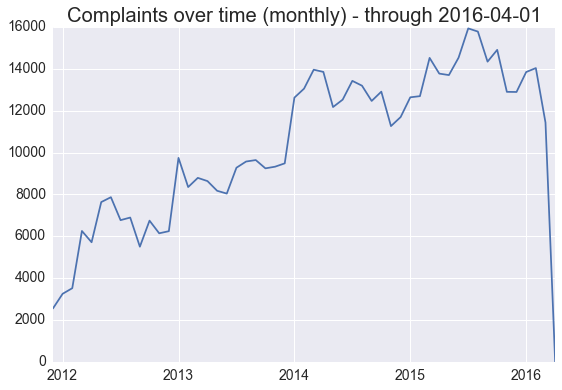

In [8]:
fig, ax = plt.subplots(1)
df['year-month'].value_counts().sort_index().plot(ax=ax)
maxdate = df['Date received'].max().strftime('%Y-%m-%d')
ax.set_title('Complaints over time (monthly) - through %s' % maxdate)
ax.set_ylim(0, ax.get_ylim()[1])

Skipping "Date received" histogram -- most common value is < 1% of all cases
Skipping "Consumer complaint narrative" histogram -- most common value is < 1% of all cases
Skipping "ZIP code" histogram -- most common value is < 1% of all cases
Skipping "Date sent to company" histogram -- most common value is < 1% of all cases
Skipping "Complaint ID" histogram -- most common value is < 1% of all cases


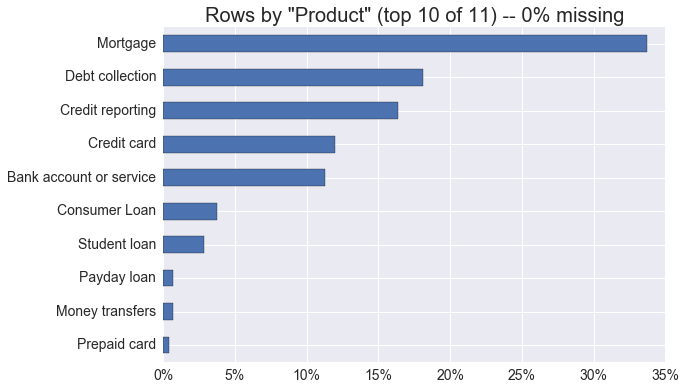

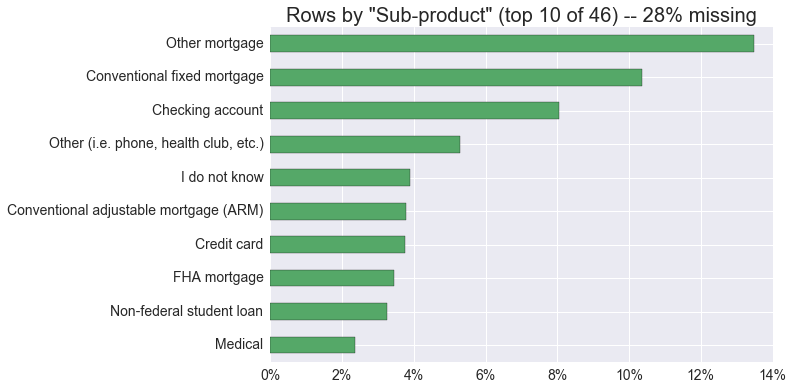

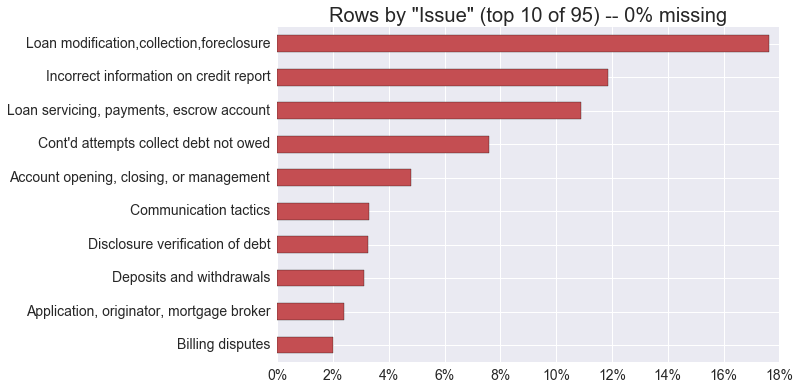

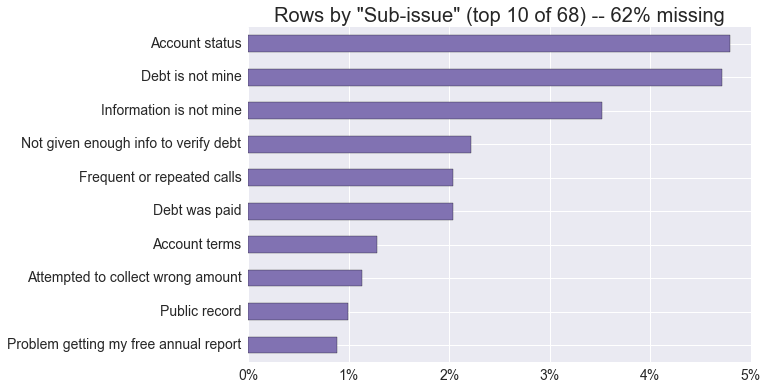

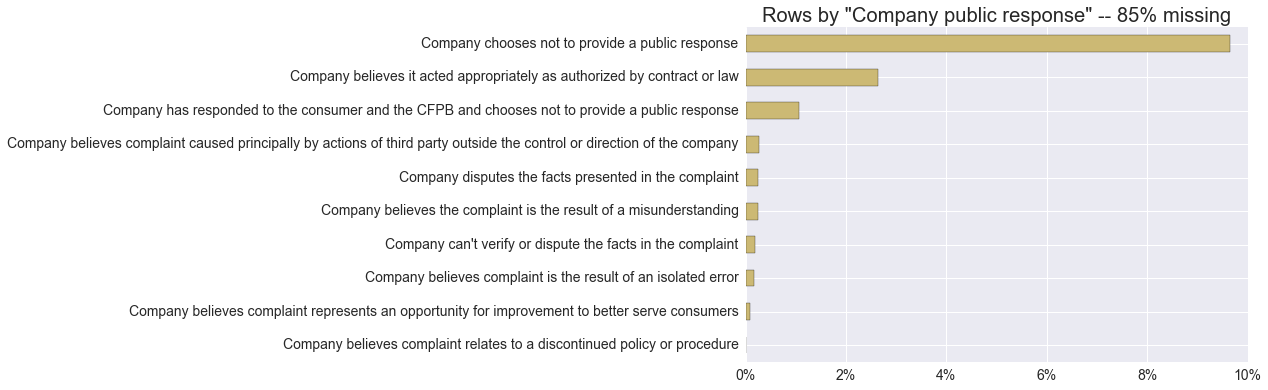

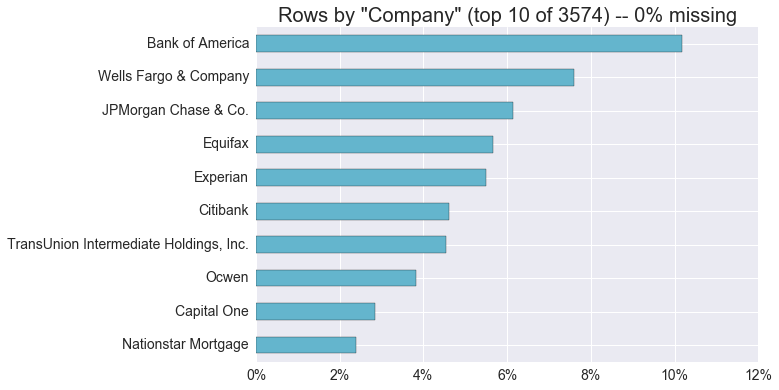

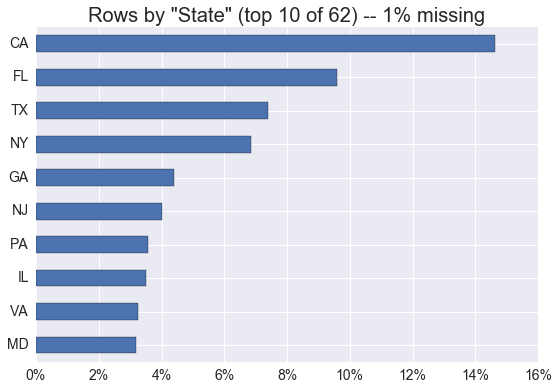

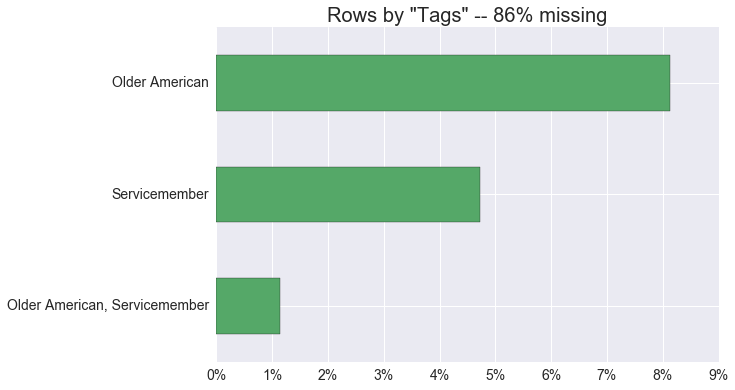

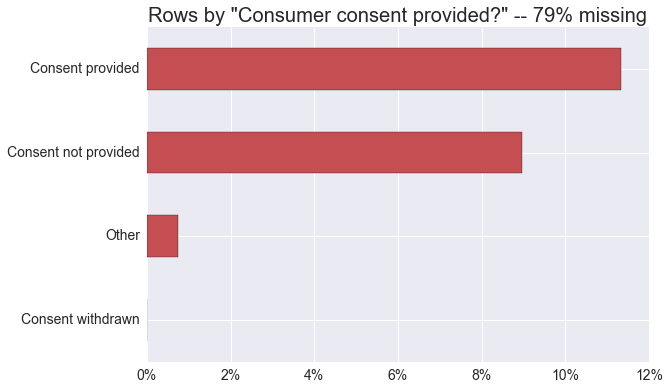

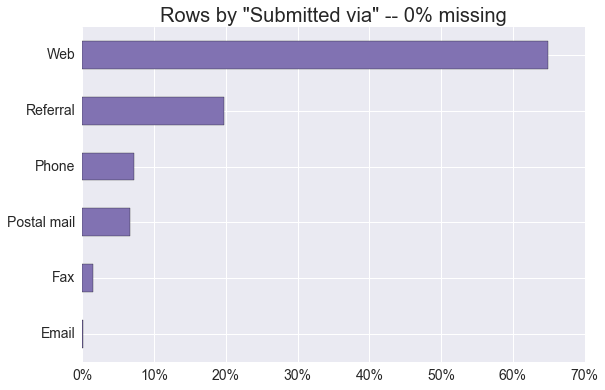

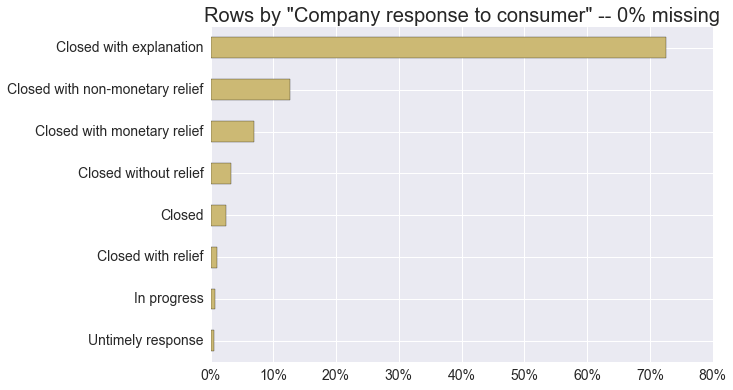

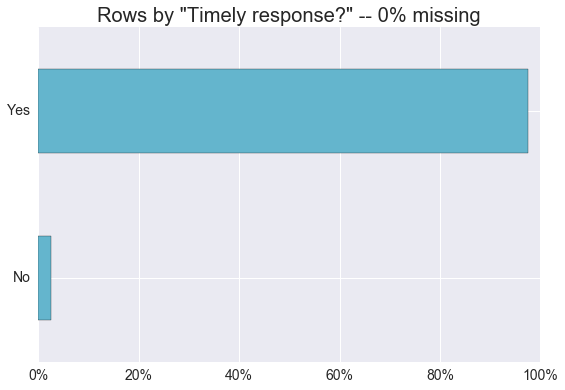

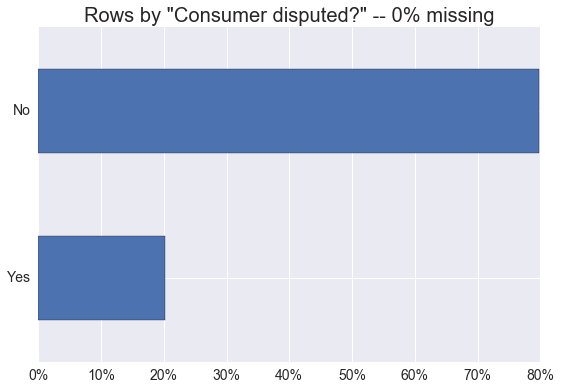

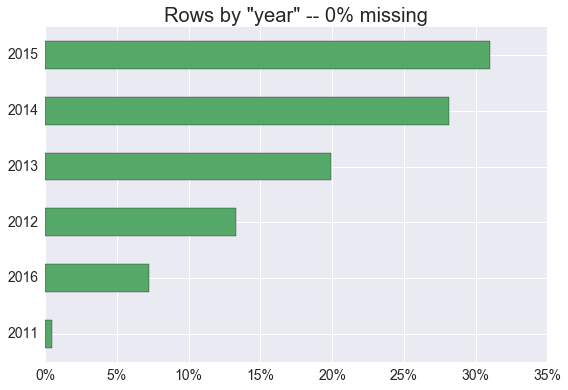

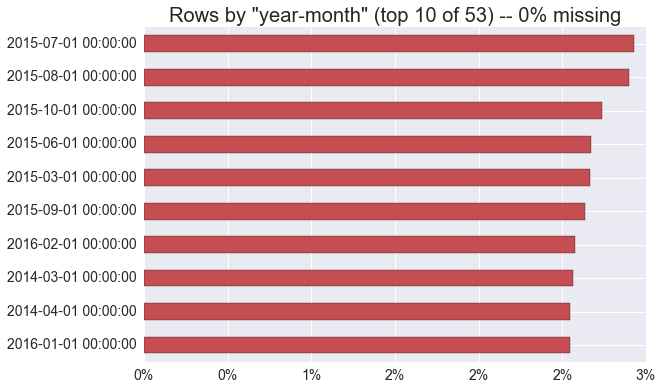

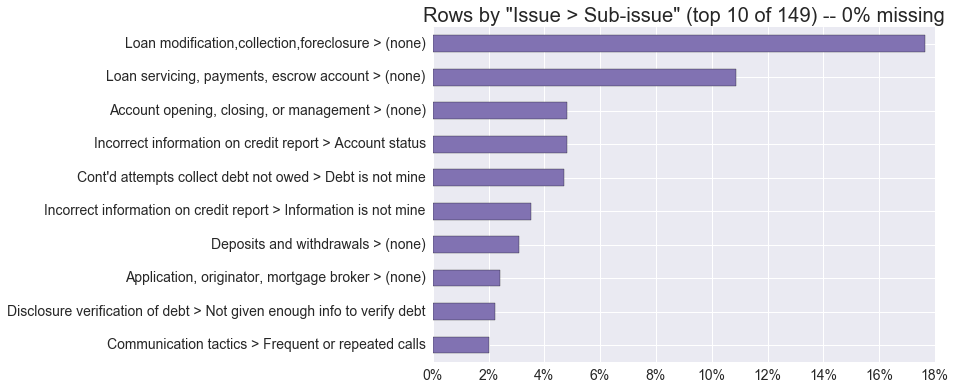

In [9]:
for col in df.columns:
    plot_top_hist(df, col)

### Column _interpretations_ can change over time -- be careful!

It seems that until 2012-2013 ish, all complaints were marked either "Closed with relief" or "Closed without relief."

Then it changed to 3 options - "Closed with explanation", "Closed with monetary relief", or "Closed with non-monetary relief"

In [10]:
s = df.groupby(['year', 'Company response to consumer']).size().unstack()
s.div(s.sum(axis=1),axis=0).fillna(0)

Company response to consumer,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Closed with relief,Closed without relief,In progress,Untimely response
year,,,,,,,,
2011,0.001177,0.009023,0.000785,0.000785,0.253040,0.714005,0.000000,0.021185
2012,0.022089,0.498883,0.090811,0.097899,0.064255,0.221844,0.000000,0.004219
2013,0.028096,0.757954,0.082384,0.130827,0.000000,0.000000,0.000000,0.000739
2014,0.023147,0.771879,0.061005,0.140561,0.000000,0.000000,0.000007,0.003402
2015,0.025061,0.775497,0.062071,0.129663,0.000000,0.000000,0.000030,0.007680
2016,0.019783,0.710929,0.058257,0.105147,0.000000,0.000000,0.095102,0.010782


In [11]:
# We'll assume that "successful" complaints were those that got some kind of relief
SUCCESSFUL_RESPONSES = ['Closed with monetary relief',
                        'Closed with non-monetary relief',
                        'Closed with relief']
df['successful'] = df['Company response to consumer'].apply(lambda s: s in SUCCESSFUL_RESPONSES)

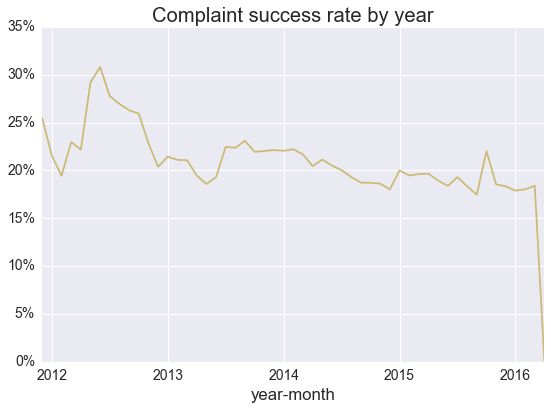

In [12]:
resolved = df[df['Company response to consumer'] != 'In progress']
s = resolved.groupby(['year-month', 'successful']).size().unstack()
s = s.div(s.sum(axis=1),axis=0).fillna(0)[True]
s.sort_index()
fig, ax = plt.subplots(1)
s.plot(kind='line', color=next_color(), ax=ax)
ax.set_ylim(0, ax.get_ylim()[1])
percentify_axis(ax, 'y')
ax.set_title('Complaint success rate by year')

------
## Section II: Look into complaint narratives
------

In [13]:
df['has_narrative'] = pd.notnull(df['Consumer complaint narrative'])
print '%.0f%% of complaints have narratives' % (df['has_narrative'].sum() * 100.0 / N)

11% of complaints have narratives


### That's a really low number. It turns out, narratives didn't exist until 2015

In [14]:
df['year'] = df['Date received'].apply(lambda d: d.year)
s = df.groupby(['year', 'has_narrative']).size().unstack()
s.div(s.sum(axis=1),axis=0).fillna(0)

has_narrative,False,True
year,,
2011,1.000000,0.000000
2012,1.000000,0.000000
2013,1.000000,0.000000
2014,1.000000,0.000000
2015,0.688608,0.311392
2016,0.767406,0.232594


### Looking further, narratives weren't consistently collected until March 2015

### Also, more recent complaints (Feb and March 2016) seem suspiciously lacking the same rate of narrative submission.

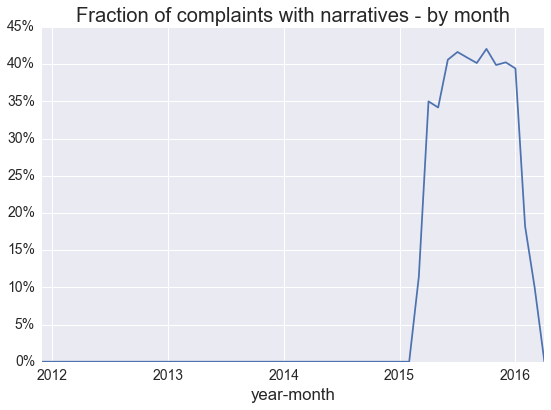

In [15]:
s = df.groupby(['year-month', 'has_narrative']).size().unstack()
s = s.div(s.sum(axis=1),axis=0).fillna(0)
fig, ax = plt.subplots(1)
s[True].plot(ax=ax)
ax.set_title('Fraction of complaints with narratives - by month')
ax.set_ylim(0, ax.get_ylim()[1])
percentify_axis(ax, 'y')

In [16]:
s[s[True] > 0]

has_narrative,False,True
year-month,,
2015-03-01,0.885500,0.114500
2015-04-01,0.650113,0.349887
2015-05-01,0.658298,0.341702
2015-06-01,0.594055,0.405945
2015-07-01,0.583694,0.416306
2015-08-01,0.591217,0.408783
2015-09-01,0.598508,0.401492
2015-10-01,0.579488,0.420512
2015-11-01,0.601194,0.398806


### Given that, I only trust narratives in the 2015-06 to 2016-01 range

In [17]:
df_narrative = df[(df['year-month'] >= dt.datetime(2015,6,1)) &
                  (df['year-month'] <= dt.datetime(2016,1,1))]
df_narrative.shape

(115144, 23)

### Are complaints with narratives categorically different from those without?

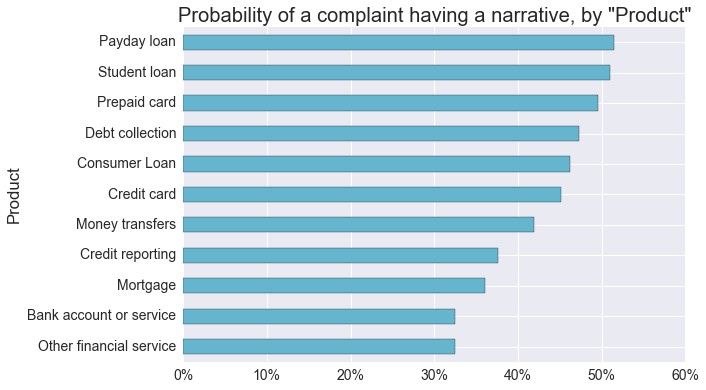

In [18]:
s = df_narrative.groupby(['Product', 'has_narrative']).size().unstack()
s = s.div(s.sum(axis=1),axis=0).fillna(0)
fig, ax = plt.subplots(1)
s[True].sort_values().plot(kind='barh', ax=ax, color=next_color())
ax.set_title('Probability of a complaint having a narrative, by "Product"')
percentify_axis(ax, which='x')

### Interestingly, complaints with narratives don't succeed any more or less often

/usr/local/lib/python2.7/site-packages/pandas/tools/plotting.py:929: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


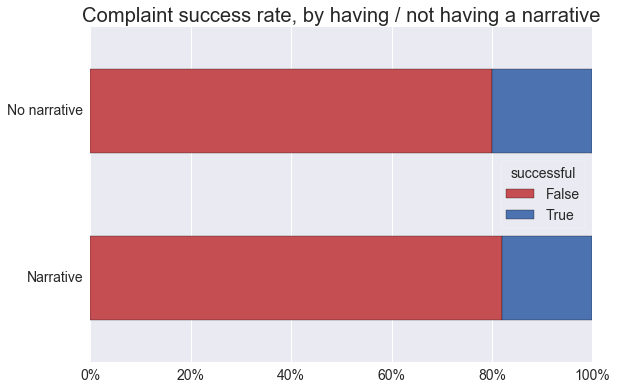

In [19]:
s = df_narrative.groupby(['has_narrative', 'successful']).size().unstack()
fig, ax = plt.subplots(1)
s.div(s.sum(axis=1),axis=0).fillna(0).plot(kind='barh', stacked=True, ax=ax, colors=[SNS_RED, SNS_BLUE])
percentify_axis(ax, 'x')
ax.set_yticklabels(['Narrative', 'No narrative'])
ax.set_ylabel('')
ax.set_title('Complaint success rate, by having / not having a narrative')